In [2]:
import tensorflow

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,LeakyReLU,ReLU,Activation,Concatenate,BatchNormalization
from tensorflow.keras.utils import plot_model

In [64]:
def discriminator_model(image_shape):
    init = RandomNormal(stddev=0.02)
    src_image=Input(shape=image_shape)
    target_image=Input(shape=image_shape)
    input_image=Concatenate()([src_image,target_image])
    
    c = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input_image)
    c = LeakyReLU(0.2)(c)
    
    c = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    c = BatchNormalization()(c)
    c = LeakyReLU(0.2)(c)
    
    c = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    c = BatchNormalization()(c)
    c = LeakyReLU(0.2)(c)
    
    c = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    c = BatchNormalization()(c)
    c = LeakyReLU(0.2)(c)
    
    c = Conv2D(1,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(c)
    output=Activation('sigmoid')(c)
    
    model = Model([src_image,target_image],output)
    
    opt = Adam(learning_rate=0.002,beta_1=0.5,beta_2=0.999)
    model.compile(loss='binary_crossentropy',optimizer=opt,loss_weights=[0.5])
    return model


In [65]:
image_shape=(256,256,3)
model = discriminator_model(image_shape)
model.summary()

plot_model(model,show_shapes=True,show_layer_names=True)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_48 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_84 (Concatenat  (None, 256, 256, 6)          0         ['input_47[0][0]',            
 e)                                                                  'input_48[0][0]']            
                                                                                                  
 conv2d_160 (Conv2D)         (None, 128, 128, 64)         6208      ['concatenate_84[0][0]'

In [66]:
from tensorflow.keras.layers import Conv2DTranspose


def encoder_block(block_input,filter_count,batchnorm=True):
    init = RandomNormal(stddev=0.002)
    e = Conv2D(filter_count,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(block_input)
    if batchnorm:
        e = BatchNormalization()(e,training=True)
    
    e = LeakyReLU(0.2)(e)
    return e
def decoder_block(block_input,skip_in,filter_count,dropout=True):
    init = RandomNormal(stddev=0.002)
    
    d = Conv2DTranspose(filter_count,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(block_input)
    d = BatchNormalization()(d,training=True)
    
    if dropout:
        d = Dropout(0.5)(d,training=True)
    d = Concatenate()([d,skip_in])
    d = Activation('relu')(d)
    return d;    

In [71]:
from tensorflow.keras.layers import Dropout

def generator_model(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.002)
    
    input_image = Input(image_shape)
    
    e1 = encoder_block(input_image,64,batchnorm=False)
    e2 = encoder_block(e1,128)
    e3 = encoder_block(e2,256)
    e4 = encoder_block(e3,512)
    e5 = encoder_block(e4,512)
    e6 = encoder_block(e5,512)
    e7 = encoder_block(e6,512)
    
    k = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    k = Activation('relu')(k)
    
    d1 = decoder_block(k,e7,512)
    d2 = decoder_block(d1,e6,512)
    d3 = decoder_block(d2,e5,512)
    d4 = decoder_block(d3,e4,512)
    d5 = decoder_block(d4,e3,256)
    d6 = decoder_block(d5,e2,128)
    d7 = decoder_block(d6,e1,64)
    
    f = Conv2DTranspose(3,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    final_image = Activation('tanh')(f)
    
    model = Model(input_image,final_image)
    return model


In [72]:
image_shape = (256,256,3)
model = generator_model(image_shape)
model.summary()

plot_model(model,show_shapes=True,show_layer_names=True)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_54 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_186 (Conv2D)         (None, 128, 128, 64)         3136      ['input_54[0][0]']            
                                                                                                  
 leaky_re_lu_158 (LeakyReLU  (None, 128, 128, 64)         0         ['conv2d_186[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_187 (Conv2D)         (None, 64, 64, 128)          131200    ['leaky_re_lu_158[0][0]

                                                                                                  
 dropout_85 (Dropout)        (None, 4, 4, 512)            0         ['batch_normalization_220[0][0
                                                                    ]']                           
                                                                                                  
 concatenate_101 (Concatena  (None, 4, 4, 1024)           0         ['dropout_85[0][0]',          
 te)                                                                 'leaky_re_lu_163[0][0]']     
                                                                                                  
 activation_124 (Activation  (None, 4, 4, 1024)           0         ['concatenate_101[0][0]']     
 )                                                                                                
                                                                                                  
 conv2d_tr

 )                                                                                                
                                                                                                  
 conv2d_transpose_104 (Conv  (None, 256, 256, 3)          6147      ['activation_129[0][0]']      
 2DTranspose)                                                                                     
                                                                                                  
 activation_130 (Activation  (None, 256, 256, 3)          0         ['conv2d_transpose_104[0][0]']
 )                                                                                                
                                                                                                  
Total params: 54429315 (207.63 MB)
Trainable params: 54419459 (207.59 MB)
Non-trainable params: 9856 (38.50 KB)
________________________________________________________________________________________________

In [73]:
def gan_model(g_model,d_model,image_shape):
    for layer in d_model.layers:
        if not isinstance(layer,BatchNormalization):
            layer.trainable = False
    
    source_image = Input(shape=image_shape)
    g_output = g_model(source_image)
    
    d_output = d_model([source_image,g_output])
    
    model = Model(source_image,[g_output,d_output])
    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    
    model.compile(loss=['binary_crossentropy','mae'],
                 optimizer = opt,loss_weights=[1,100])
    
    return model

In [74]:
image_shape = (256,256,3)
d_model = discriminator_model(image_shape)
g_model = generator_model(image_shape)

f_model = gan_model(g_model,d_model,image_shape)
f_model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_58 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_27 (Functional)       (None, 256, 256, 3)          5442931   ['input_58[0][0]']            
                                                          5                                       
                                                                                                  
 model_26 (Functional)       (None, 8, 8, 1)              2771393   ['input_58[0][0]',            
                                                                     'model_27[0][0]']            
                                                                                           

In [75]:
import numpy as np
def gen_real_samples(dataset,number,patch_shape):
    trainA, trainB = dataset
    ix = np.randint(0,trainA.shape[0],number)
    X1,X2 = trainA[ix],trainB[ix]
    y = np.ones((number,patch_shape,patch_shape,1))
    return [X1,X2],y

In [76]:
def gen_fake_samples(g_model,samples,patch_shape):
    X1 = g_model.predict(samples)
    y = np.zeroes((len(X1),patch_shape,patch_shape,1))
    return X1,y

In [77]:
from matplotlib import pyplot as plt
def summarizer(step,g_model,dataset,n_samples=3):
    [X_realA,X_realB],_ = gen_real_samples(dataset,n_samples,1)
    
    X_fakeB,_ = gen_fake_samples(g_model,X_realA,1)
    
    X_realA = (X_realA + 1)/2.0
    X_realB = (X_realB + 1)/2.0
    X_fakeB = (X_fakeB + 1)/2.0
    
    for i in range(n_samples):
        plt.subplot(3,n_samples,1+i)
        plt.axis('off')
        plt.imshow(X_realA[i])
        
    for i in range(n_samples):
        plt.subplot(3,n_samples,1+i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        
    for i in range(n_samples):
        plt.subplot(3,n_samples,1+i)
        plt.axis('off')
        plt.imshow(X_realB[i])
        
    filename = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    
    print('>Saved: %s'%(filename))

In [78]:
def train(d_model,g_model,gan_model,dataset,epochs=10,batch_num=1):
    patch = d_model.output_shape[1]
    
    trainA,trainB = dataset
    
    steps = (len(trainA))*epochs
    
    for i in range(steps):
        [X_realA,X_realB],y_real = gen_real_samples(dataset,batch_num,patch)
        
        X_fakeB,y_fake = gen_fake_samples(g_model,X_realA,patch)
        
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

In [1]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np


def load_images(image_path,size=(256,512)):
    source_list,target_list = list(),list()
    
    for filename in listdir(path):
        pixels = load_img(path+filename,target_size=size)
        pixels = img_to_array(pixels)
        
        sat_img,map_img = pixels[:,:256],pixels[:,256:]
        source_list.append(sat_img)
        target_list.append(map_img)
        
    return [asarray(source_list),asarray(target_list)]


In [2]:
path = "C:/Users/uzzwa/Downloads/maps/maps/train/"

[src_images,target_images] = load_images(path)
print('Loaded: ', src_images.shape, target_images.shape)


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


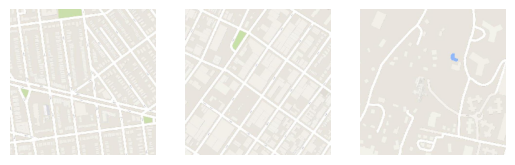

In [4]:
import matplotlib.pyplot as plt
n_samples = 3

for i in range(n_samples):
    plt.subplot(2,n_samples,1+i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
        
        
for i in range(n_samples):
    plt.subplot(2,n_samples,1+i)
    plt.axis('off')
    plt.imshow(target_images[i].astype('uint8'))
    
pyplot.show()
        

In [5]:
image_shape = (256,256,3)

data = [src_images,target_images]


def preprocess_images(data):
    X1,X2 = data[0],data[1]
    
    X1= (X1-127.5)/127.5
    X2= (X2-127.5)/127.5
    
    return [X1,X2]

dataset = preprocess_images(data)

In [7]:
import tensorflow

In [8]:
model = tensorflow.keras.models.load_model("C:/Users/uzzwa/Downloads/g_modelf.h5")

In [9]:
def plot_images(src_img,gen_img,tar_img):
  images = vstack((src_img,gen_img,tar_img))

  images = (images+1)/2.0
  titles = ['Source','Generated','Target']

  for i in range(len(images)):
    plt.subplot(1,3,1+i)
    plt.axis('off')
    plt.title(titles[i])
    plt.imshow(images[i])
  plt.show()

1/1 [==============================] - 1s 1s/step


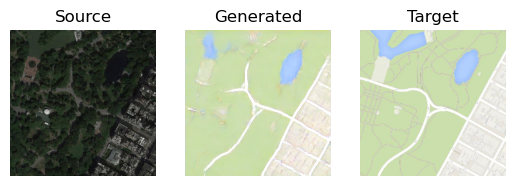

In [10]:
[X1,X2] = dataset

ix = np.random.randint(0,len(X1),1)
src_img, tar_img = X1[ix],X2[ix]

gen_img = model.predict(src_img)

plot_images(src_img,gen_img,tar_img)

In [11]:
import tensorflow as tf

In [12]:
def calculate_ssim(real_image,target_image, generated_image,k):
    # Ensure images are scaled to [0, 1]
        
    real_image = (real_image+1)/2.0
    generated_image = (generated_image+1)/2.0
    
    real_image = tf.convert_to_tensor(real_image)
    generated_image = tf.convert_to_tensor(generated_image)
    
    real_image = tf.image.convert_image_dtype(real_image, tf.float32)
    generated_image = tf.image.convert_image_dtype(generated_image, tf.float32)
    
    # Calculate SSIM
    ssim_value = tf.image.ssim(real_image, generated_image, max_val=1.0)
    return ssim_value

In [13]:
ssim_values = []

In [14]:
import numpy as np

In [ ]:
for i in range(20):
    src_img,tar_img = X1[i],X2[i]
    gen_img = model.predict(src_img)
    ssim_val = calculate_ssim(src_img,tar_img,gen_img,i)
    ssim_values.append(ssim_val.numpy())
    
avg_ssim = np.mean(ssim_values)
print(avg_ssim)

In [ ]:
train(d_model,g_model,gan_model,dataset,epochs=10,batch=1)

In [ ]:
model.save(g_model.h5)